# Define the system  

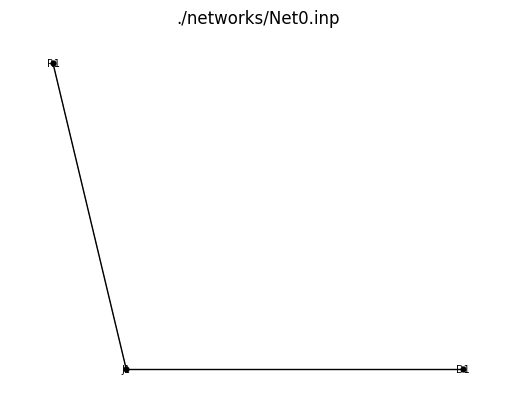

<Axes: title={'center': './networks/Net0.inp'}>

In [3]:
import wntr
import wntr_quantum
import numpy as np
import matplotlib.pyplot as plt
# Create a water network model
inp_file = './networks/Net0.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

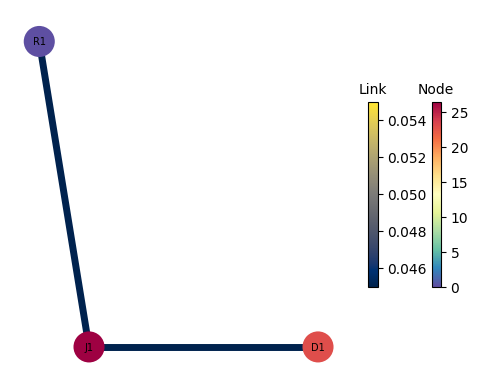

<Axes: >

In [4]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
flow_at_5hr = results.link['flowrate'].loc[0, :]
wntr.graphics.plot_network(wn, link_attribute=flow_at_5hr, 
                           node_attribute=pressure_at_5hr, 
                           node_size=500, 
                           link_width=5, 
                           node_labels=True,
                           link_cmap=plt.cm.cividis)

In [5]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_pressure

array([26.477, 22.954], dtype=float32)

In [6]:
ref_rate = results.link['flowrate'].values[0]
ref_rate

array([0.05, 0.05], dtype=float32)

In [7]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 26.477, 22.954], dtype=float32)

## Run with the QUBO Polynomial Solver

In [8]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [37]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 5
step = (2./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0, var_base_name="x")

nqbit = 5
step = (100/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 0.000000 => 100.000000 (res: 3.225806)
Flow Encoding : -2.000000 => -0.000000 | 0.000000 => 2.000000 (res: 0.064516)


Solve the system classically

In [38]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, cvgd = net.classical_solutions()
ref_sol / ref_values

array([1.   , 1.   , 0.999, 0.998])

In [39]:
encoded_ref_sol/ ref_values

array([0.987, 0.987, 1.003, 0.985])

In [40]:
P0, P1, P2, P3 = net.matrices

In [41]:
p0 = P0.reshape(
    -1,
) + P1[
    :, :2
].sum(-1)
p0

array([ 0.   ,  1.766, 99.077,  0.652])

In [42]:
net.convert_solution_from_si(ref_sol)

array([ 1.766,  1.766, 86.797, 75.168])

In [46]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
from dwave.samplers import SimulatedAnnealingSampler

sampler = SimulatedAnnealingSampler()
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.solve(model, strength=1e6, sampler=sampler, num_sweeps=10000, num_reads=1000)
sol = net.extract_data_from_model(model)

In [47]:
solutions,energies,statuses = net.analyze_sampleset()
for e,s in zip(energies,statuses):
    print(e,s)

-9563.109226629138 True
-9562.710552453995 True
-9562.517971858382 True
-9562.497054494917 True
-9562.44983253628 True
-9562.44983253628 True
-9562.435655124485 True
-9562.36700142175 True
-9562.33702659607 True
-9562.293940618634 True
-9562.272314548492 True
-9562.245232239366 True
-9562.216201871634 True
-9562.144584052265 True
-9562.137716375291 True
-9562.102543711662 True
-9562.102543711662 True
-9562.04365451634 True
-9562.0264801234 True
-9562.00990793854 True
-9561.989746190608 True
-9561.970614813268 True
-9561.926697686315 True
-9561.894538357854 True
-9561.864012047648 True
-9561.769913449883 True
-9561.695568844676 True
-9561.689212732017 True
-9561.666829064488 True
-9561.6088957116 True
-9561.504538975656 True
-9561.433358639479 True
-9561.391018666327 True
-9561.329872056842 True
-9561.322393581271 True
-9561.283868931234 True
-9561.275107614696 True
-9561.24111750722 True
-9561.2323821038 True
-9561.17423441261 True
-9561.134120248258 True
-9561.07260362804 True
-9561.0

[]

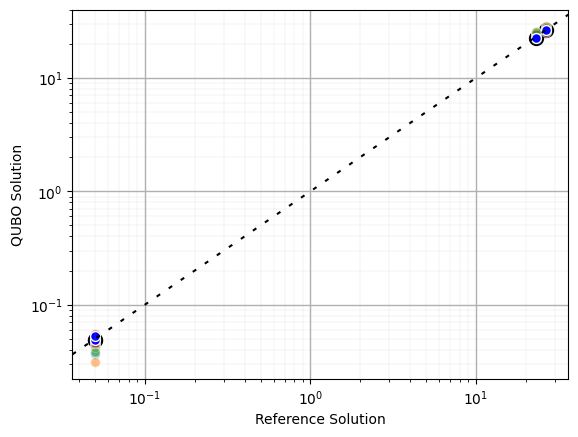

In [69]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values, encoded_ref_sol, c='black', s=100, label='Best possible solution')
for s in solutions[1:5]:
    plt.scatter(ref_values, s, s=50, lw=1, alpha=0.5, edgecolors='w', label='Sampled solution')
plt.scatter(ref_values, solutions[0], s=50, lw=1, c='blue', edgecolors='w', label='Best sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')
# plt.legend()
# plt.xlim([0.01,0.1])
# plt.ylim([0.01,0.1])

# plt.xlim([10,50])
# plt.ylim([10,50])
plt.loglog()


In [57]:
net.qubo.qubo_dict.num_variables

72

999998.1773075246
-2000000.0
-2000000.0
1000005.6999586402
999996.3546150491
1000000.0
-2000000.0
-2000000.0
-0.03329864724245577
0.06659729448491154
-0.06659729448491154
0.13319458896982309
999955.6967091897
0.06659729448491154
-0.13319458896982309
0.13319458896982309
-0.26638917793964617
-2000000.0
-2000000.0
1000000.2257171796
999999.5443268812
1000000.0
1000000.9765445201
1000000.0
-0.008324661810613943
0.016649323621227886
-2000000.0
0.016649323621227886
-0.03329864724245577
-2000000.0
-0.26638917793964617
0.5327783558792923
-0.5327783558792923
1.0655567117585847
1000041.0643098262
999364.4931353139
999919.6912747989
-0.06659729448491154
0.13319458896982309
0.5327783558792923
-1.0655567117585847
1.0655567117585847
-2.1311134235171694
-2000000.0
0.13319458896982309
-0.26638917793964617
-2000000.0
1000000.559306534
999999.0886537622
1000000.0
1000002.2312476977
1000000.0
-0.016649323621227886
0.03329864724245577
1000000.0628233965
1000000.0
-0.13319458896982309
0.26638917793964617
1

(array([100.,   0.,   0.,   0.,   0.,   0., 670.,   0.,   0.,  50.]),
 array([-2000000.   , -1699929.212, -1399858.423, -1099787.635,  -799716.846,  -499646.058,  -199575.27 ,   100495.519,   400566.307,   700637.096,  1000707.884]),
 <BarContainer object of 10 artists>)

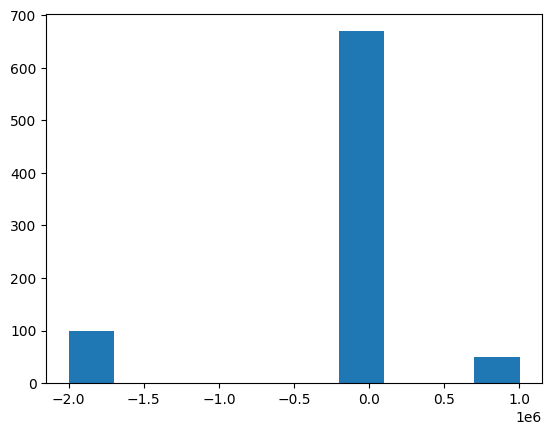

In [96]:
v=[]
for i in net.qubo.qubo_dict.iter_quadratic():
    v.append((i[2]))
    print(i[2])

plt.hist(v)
    

In [90]:
v

[]

In [58]:
print(model.__str__())

cons:
mass_balance[J1]:   ((expected_demand[J1]-flow[P1])+flow[P2])
mass_balance[D1]:   (expected_demand[D1]-flow[P2])
approx_darcy_wesibach_headloss[P1]:   (((((-(dw_resistance_0[P1]))-(dw_resistance_1[P1]*flow[P1]))-(dw_resistance_2[P1]*(flow[P1]**2.0)))+source_head[R1])-head[J1])
approx_darcy_wesibach_headloss[P2]:   (((((-(dw_resistance_0[P2]))-(dw_resistance_1[P2]*flow[P2]))-(dw_resistance_2[P2]*(flow[P2]**2.0)))+head[J1])-head[D1])

vars:
flow[P1]:   flow[P1]
flow[P2]:   flow[P2]
head[J1]:   head[J1]
head[D1]:   head[D1]



# Embed the problem

In [100]:
import dwave_networkx as dnx
from minorminer import find_embedding
from dwave.embedding import embed_qubo, majority_vote, chain_break_frequency

In [113]:
net.qubo.qubo_dict.to_qubo()[0]

{('x_004_004', 'x_002_001'): 999996.3546150491,
 ('x_002_001*x_004_004', 'x_002_001'): -2000000.0,
 ('x_002_001*x_004_004', 'x_004_004'): -2000000.0,
 ('x_004_003', 'x_002_001'): 999998.1773075246,
 ('x_004_003', 'x_004_004'): 1000005.6999586402,
 ('x_004_003', 'x_002_001*x_004_004'): 1000000.0,
 ('x_002_001*x_004_003', 'x_002_001'): -2000000.0,
 ('x_002_001*x_004_003', 'x_004_003'): -2000000.0,
 ('x_003_003', 'x_004_004'): -0.26638917793964617,
 ('x_003_003', 'x_002_001*x_004_004'): 0.5327783558792923,
 ('x_003_003', 'x_004_003'): -0.13319458896982309,
 ('x_003_003', 'x_002_001*x_004_003'): 0.26638917793964617,
 ('x_001_001', 'x_003_003'): 999762.5552928579,
 ('x_003_003*x_001_001', 'x_004_004'): 0.5327783558792923,
 ('x_003_003*x_001_001', 'x_002_001*x_004_004'): -1.0655567117585847,
 ('x_003_003*x_001_001', 'x_004_003'): 0.26638917793964617,
 ('x_003_003*x_001_001', 'x_002_001*x_004_003'): -0.5327783558792923,
 ('x_003_003*x_001_001', 'x_003_003'): -2000000.0,
 ('x_003_003*x_001_001

In [125]:
target_graph = dnx.pegasus_graph(6)
embedding = find_embedding(net.qubo.qubo_dict.to_qubo()[0], target_graph)

In [132]:
embedding

{'x_004_004': [217, 218, 632, 634, 234, 633],
 'x_002_001': [647, 228, 229],
 'x_002_001*x_004_004': [606, 607, 609, 238, 608],
 'x_004_003': [584, 583, 178, 581, 582],
 'x_002_001*x_004_003': [162, 562, 648, 263, 262, 563, 564],
 'x_003_003': [524, 294, 293, 291, 292],
 'x_001_001': [529, 527, 528],
 'x_003_003*x_001_001': [301, 304, 303, 302],
 'x_004_005': [622, 624, 623, 212, 213],
 'x_002_001*x_004_005': [543, 157, 227, 569, 567, 568],
 'x_003_004': [271, 588, 554, 273, 272],
 'x_003_004*x_001_001': [286, 289, 287, 288],
 'x_004_002': [576, 577, 579, 578, 207],
 'x_004_001': [666, 667, 243, 244, 668, 669],
 'x_004_002*x_004_001': [167, 628, 627, 169, 168],
 'x_003_002': [338, 251, 252, 253, 599, 598, 233],
 'x_003_002*x_001_001': [284, 281, 283, 282],
 'x_003_001': [309, 484, 306, 308, 307],
 'x_003_005': [296, 519, 299, 298, 297],
 'x_003_001*x_003_005': [206, 497, 499, 261, 498],
 'x_004_002*x_002_001': [673, 629, 269, 267, 268],
 'x_002_001*x_004_001': [572, 574, 573],
 'x_004_

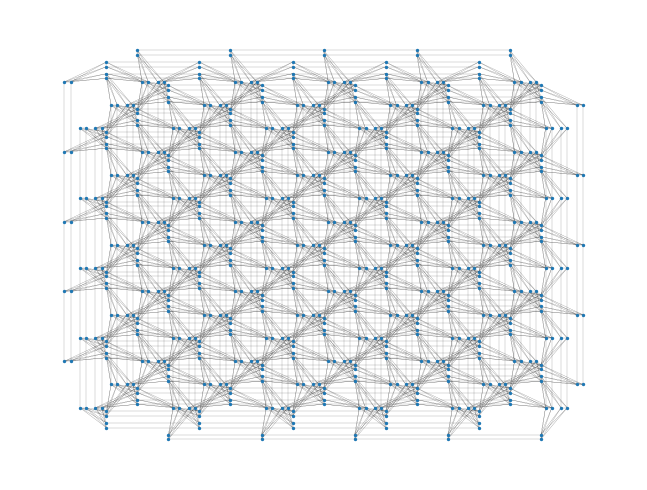

In [124]:
dnx.draw_pegasus(dnx.pegasus_graph(6),  node_size=2, width=0.1)

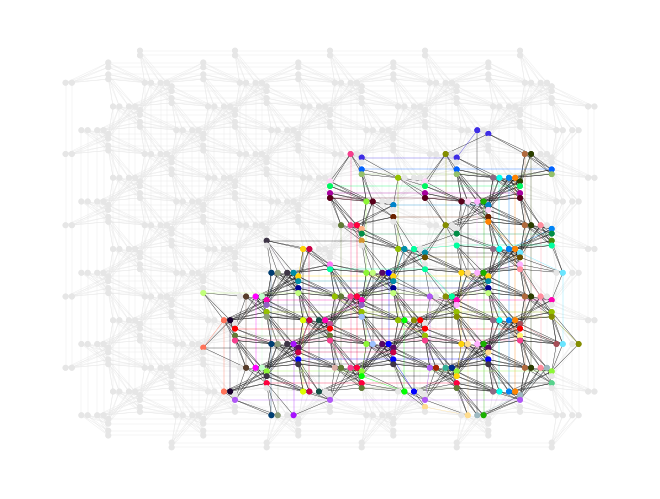

In [131]:
dnx.draw_pegasus_embedding(target_graph, embedding, node_size=10, width=0.25)